# Analysis of OmniScape correlation with eBird sightings


In [1]:
import os
import pandas as pd
import numpy as np
import sys
from IPython.core.display import HTML

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet
from scipy import stats
from sklearn.linear_model import LinearRegression


In [3]:
# Point to where you expanded Omniscape.zip
DATA_PATH = "data/Omniscape"

For a given run, we can read a dataframe contains, for each square, the:
* Number of checklists
* Number of checklists containing the bird
* Total number of birds (of the given species) seen
* average habitat around the square (counting 1 as habitat and 0 as non-habitat)
* max habitat around the square
* average repopulation around the square (counting as 0 out of habitat of course)
* max repopulation around the square.

I look for the correlation between:
* Average number of birds seen (the BirdRatio),
* Max repopulation (MaxRepopRange).

Why max repopulation and not average?  Because average repopulation mixes two concerns: (a) how much habitat there is around, and (b) how high the repopulation is in that habitat.  This confounds the signal.  It is much cleaner to look at the correlation between BirdRatio and MaxRepopRange.

In [4]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [5]:
def read_bird_df(bird_out):
    val_fn = "validation_cum_currmap.csv"
    obs_csv_path = os.path.join(DATA_PATH, "output", bird_out, val_fn)
    df = pd.read_csv(obs_csv_path)
    return df

In [10]:
plt.rcParams["figure.figsize"] = [5, 3]


In [11]:
def plot_bird_ratios_locations(bird, bird_output, max_checklists=100, bird_name=None):
    val_fn = "validation_cum_currmap.csv"
    obs_csv_path = os.path.join(DATA_PATH, "output", bird_output, val_fn)
    df = read_bird_df(bird_output)
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    # Computes the MaxRepopRange correctly according to output range.
    df["max_repop"] = df.apply(lambda row: row["max_repop"] * 255, axis=1)
    step = df["max_repop"].quantile(0.9) / 9
    df["MaxRepopRange"] = df.apply(lambda row: min(9, int(row["max_repop"] / step)) / 10, axis=1)
    sizes = np.array(df.groupby("MaxRepopRange")["Square"].count()) # Counts the locations. 
    ys = np.array(df.groupby("MaxRepopRange")["BirdRatio"].mean())
    xs = np.array(list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys()))
    corr = wcorr(xs, ys, sizes)
    print("Correlation:", corr)
    reg = LinearRegression().fit(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
    r_square = reg.score(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
    print("R^2:", r_square)
    norm = plt.Normalize(vmin=min(sizes), vmax=max(sizes))
    fig, ax = plt.subplots()
    ax.scatter(xs, ys, s=sizes / 4, alpha=0.5)
    ax.set_xlabel("Cumulative current")
    ax.set_ylabel("Average sightings per checklist")
    ax.set_xlim((-0.05, 1))
    ymin, ymax = np.min(ys), np.max(ys)
    ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
    ax.set_ylim((ylmin, ylmax))
    ax.grid(True)
    fig.tight_layout()
    print("Average on locations with max {} checklists".format(max_checklists))
    plt.show()
    fig.savefig("Figures/OmniscapeSightingsVsConnectivity{}.pdf".format(bird), format="pdf")


Correlation: 0.8895503268925148
R^2: 0.7912997840745801
Average on locations with max 10000 checklists


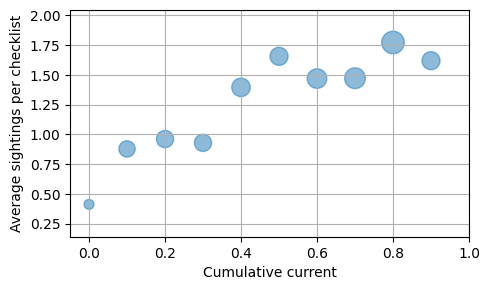

In [12]:
plot_bird_ratios_locations("acowoo", "acowoo_CA", max_checklists=10000, bird_name="Acorn Woodpecker")


Correlation: 0.9845277781704957
R^2: 0.9692949459893332
Average on locations with max 10000 checklists


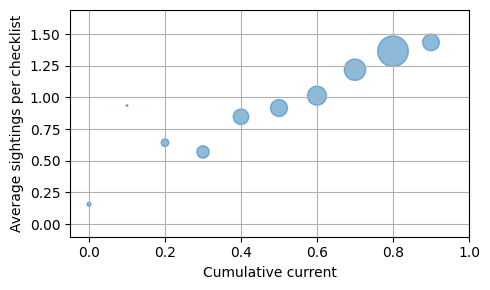

In [13]:
plot_bird_ratios_locations("stejay", "stejay_CA_h2_S3", max_checklists=10000, bird_name="Steller's Jay")

Average on locations with max 10000 checklists
Average on locations with max 10000 checklists


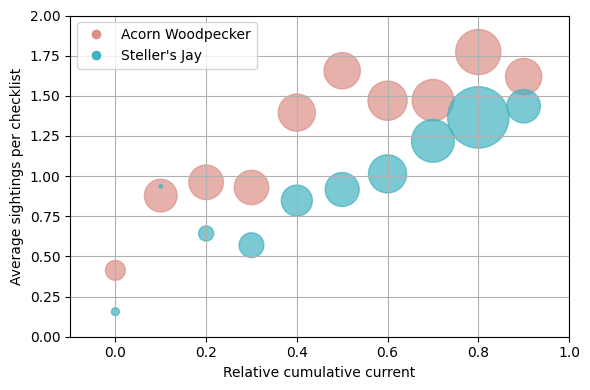

In [19]:
from matplotlib.lines import Line2D  # for legend handle

def plot_birds_ratios(bird_ls, max_checklists=10000, n_bins=10):
    fig, ax = plt.subplots(figsize=(6, 4))

    cmap = colorcet.cm.cyclic_isoluminant_r
    # cmap = plt.cm.inferno
    num_birds = len(bird_ls)
    colors = cmap(np.linspace(0, 1 - 1/num_birds, num_birds))
    colormap = {b: c for b, c in zip(bird_ls, colors)}
    for bird in bird_ls:
        df = read_bird_df("acowoo_CA" if bird == "Acorn Woodpecker" else "stejay_CA_h2_S3")
        # limit to squares where max hab > 0.9
        df = df.loc[lambda r : r["max_hab"] > 0.9]
        df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
        # Computes the MaxRepopRange correctly according to output range.
        df["max_repop"] = df.apply(lambda row: row["max_repop"] * 255, axis=1)
        step = df["max_repop"].quantile(0.9) / 9
        df["MaxRepopRange"] = df.apply(lambda row: min(9, int(row["max_repop"] / step)) / 10, axis=1)
        sizes = np.array(df.groupby("MaxRepopRange")["Square"].count()) # Counts the locations. 
        ys = np.array(df.groupby("MaxRepopRange")["BirdRatio"].mean())
        xs = np.array(list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys()))
        ax.scatter(xs, ys, s=sizes, color=colormap[bird], alpha=0.7, label=bird)
        fig.tight_layout()
        print("Average on locations with max {} checklists".format(max_checklists))

    ax.set_xlabel(r"Relative cumulative current")
    ax.set_ylabel("Average sightings per checklist")
    ax.set_xlim((-0.1, 1.0))
    ax.set_ylim((0, 2.0))
    ax.grid(True)
    fig.tight_layout()

    # add a legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=b, markersize=8) for b, c in colormap.items()]
    ax.legend(handles=handles, loc='upper left')

    plt.show()
    
    fig.savefig("Figures/SightingsVsCurrent.pdf", format="pdf")

plot_birds_ratios(["Acorn Woodpecker", "Steller's Jay"])